In [112]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from moviepy.editor import VideoFileClip

%matplotlib inline

## 1. Camera Calibration
Compute the transformation between 3D objects and 2D image points.

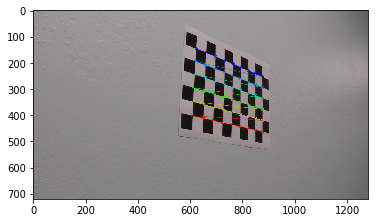

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cal*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        checkerboard_img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
plt.imshow(checkerboard_img)

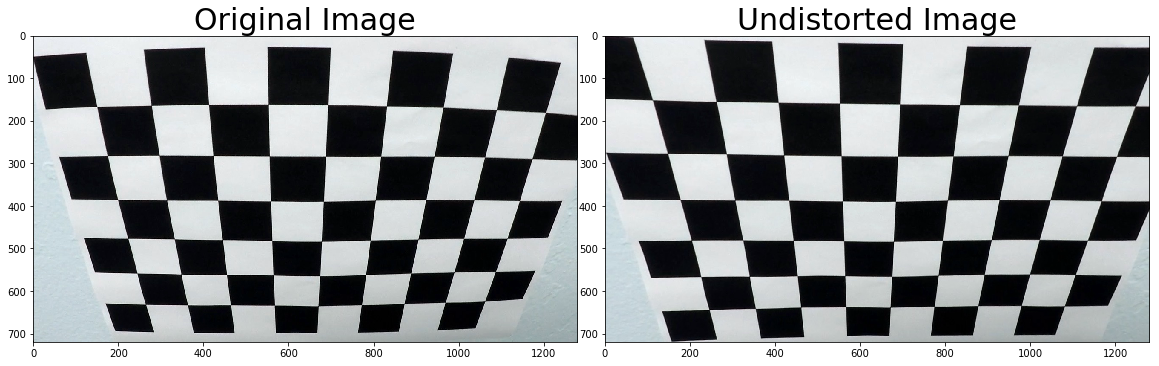

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_calibration2.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace=0.2, wspace=0.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
def calibrate_camera(cam_files, nx=9, ny=6):
    """Calibrate camera to correct for image distortion
    
    Parameters
    ----------
    cam_files : str
        Filepath for calibration imgs (ex: ./camera_cal/calibration*.jpg)
        
    nx : int
        Number of corners to find horizontally
        
    ny: int
        Number of corners to find vertically
    
    Returns
    -------
    mtx : numpy array
        Camera matrix
        
    dist : numpy array
        Distortion coefficients
    """
    cal_imgs = glob.glob(cam_files)

    objpoints = []  # 3D points
    imgpoints = []  # 2D points

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname = cal_imgs[0]
    for fname in cal_imgs:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist

## 2. Distortion Correction
To ensure the geometrical shape of objects is represented consistently no matter where they appear in the the image.

In [5]:
def undistort(img, mtx, dist):
    """Applies image distortion correction
    
    Parameters
    ----------
    img : numpy array
        Image represented as array
    
    mtx : numpy array
        Camera matrix
        
    dist : numpy array
        Distortion coefficients
    
    Returns
    -------
    undist : numpy array
        Undistorted image 
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [6]:
mtx, dist = calibrate_camera('./camera_cal/calibration*.jpg', 9, 6)

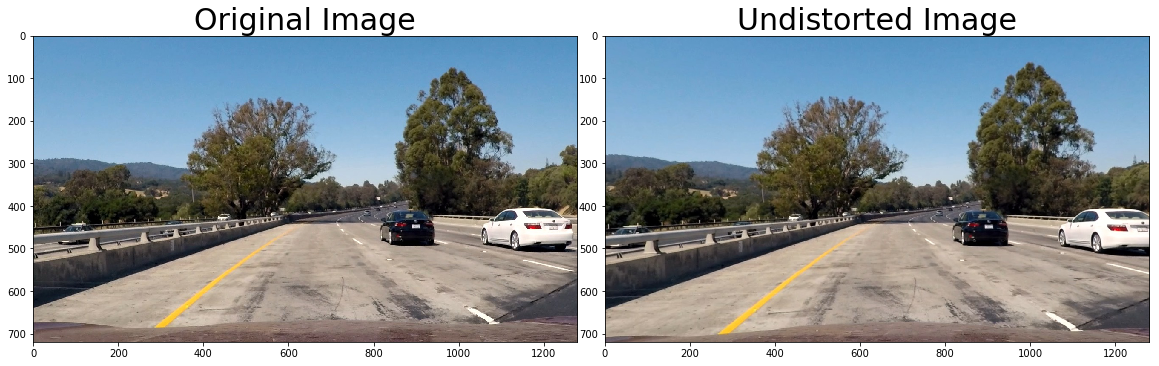

In [7]:
img = cv2.imread("output/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)

Although it might not look undistorted, you can somewhat see the car's hood is changed at the bottom of the image 😅

## 3. Color and Gradient Threshold
**Sobel**: The heart of the Canny Algorithm. The Sobel Function takes the derivative of an image in the *x* and *y* direction. Taking the gradient in the:
* *x* direction emphasizes edges closer to the vertical
* *y* direction emphasizes edgers closer to the horizontal

In [10]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    """Apply sobel function and threshold on absolute values to emphasize edges
    
    Parameters
    ----------
    img : numpy array
        Image represented as array
    
    orient : str
        Direction of gradient
    
    sobel_kernel : int
        Size of kernel (Default is 3x3)
    
    thresh : tuple of ints
        Min and max of gradient threshold
    
    Returns
    -------
    binary_output : numpy array
        Image with threshold applied to abs value of gradient
    """
    # Calculate gradient
    if orient == 'x':
        sobel_img = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel_img = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Get abs value of gradient
    abs_sobel = np.absolute(sobel_img)
    # Scale to (0 - 255) then convert to np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude is >= thresh_min and <= thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return mask as output image
    return binary_output

In [125]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """Apply sobel function and apply threshold on dir of gradient
    
    Parameters
    ----------
    img : numpy array
        Image represented as array
    
    sobel_kernel : int
        Size of kernel (Default is 3x3)
    
    thresh : tuple of floats
        Min and max of gradient threshold
        
    Returns
    -------
    binary_output : numpy array
        Image with threshold applied to dir of gradient
    """
    # Take the gradient in x and y
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the direction of the abs value of the gradients
    grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Create a binary image of 1s where threshold is met
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # Return this mask as image
    return binary_output

In [12]:
def hls_select(img, thresh=(170, 255)):
    """Threshold the S-channel of HLS
    
    Parameters
    ----------
    img : numpy array
        Image represented as array
    
    thresh : tuple of ints
        Min and max of threshold
    
    Returns
    -------
    binary_output : numpy array
        Image with S-channel thresholded
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [128]:
def process_img(img, ksize=3, sx_thresh=(20, 100)):
    """Preprocess image and apply all thresholds
    
    Parameters
    ----------
    img : numpy array
        Image represented as array
    
    k_size : int
        Kernel size
    
    sx_thresh : tuple of ints
        Min and max of gradient in the x dir
    
    Returns
    -------
    combined_binary : numpy array
        Image with edges emphasized
    """
    # Convert img to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply Sobel
    gradx = abs_sobel_thresh(gray_img, orient='x', sobel_kernel=ksize, thresh=sx_thresh)
    # Convert to HLS space and threshold S channel
    s_binary = hls_select(img)
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gradx)
    combined_binary[(s_binary == 1) | (gradx == 1)] = 1
    return combined_binary

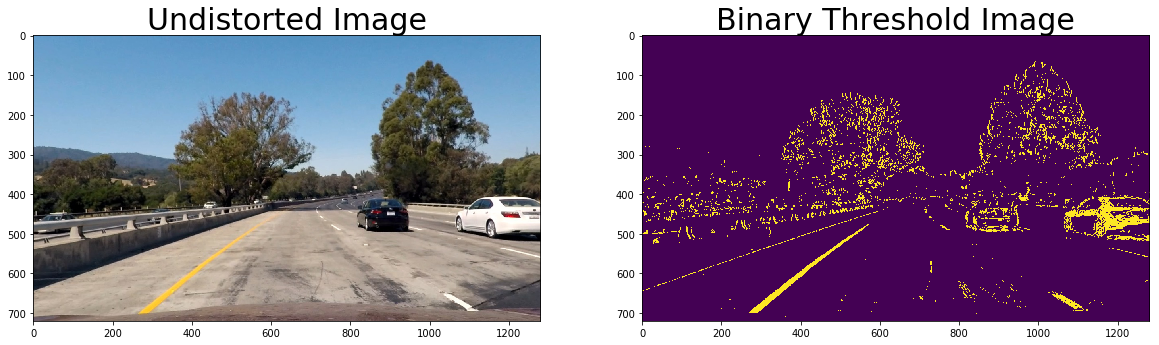

In [139]:
sx_thresh = (30, 150)
binary_threshold = process_img(undistorted_image, sx_thresh=sx_thresh)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistorted_image)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(binary_threshold)
ax2.set_title('Binary Threshold Image', fontsize=30)

## 4. Perspective Transformation
Transform an image such that we are effectively viewing an object from a different angle or direction. We want a bird's eye view of the lane.

In [120]:
def warp(img):
    """Warp image to get top down view
    
    Parameters
    ----------
    img : numpy array
        Image represented as array
    
    Returns
    -------
    warped : numpy array
        Top down view of original img
        
    M : numpy array
        Perspective transformation matrix
        
    M_inv : numpy array
        Inverse of transformation matrix
    """
    h,w = img.shape[:2]
    src = np.float32([[1175, h], [200, h], [550, 460], [750, 460]])
    dst = np.float32([[w, h], [0, h], [0, 0], [w, 0]])

    # use getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    # use warpPerspective() to warp img to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, M_inv

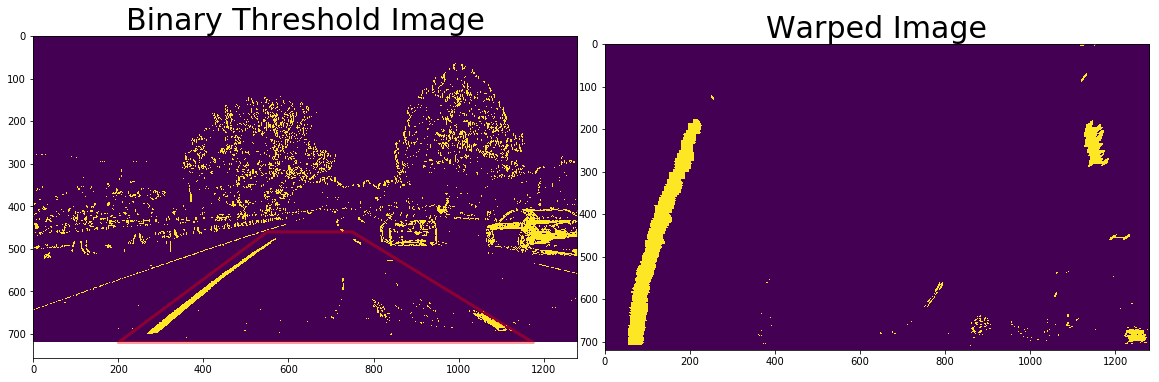

In [140]:
h,w = binary_threshold.shape[:2]
src = np.float32([[1175, h], [200, h], [550, 460], [750, 460]]) 
warped_img, M, Minv = warp(binary_threshold)

# Visualize warp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(binary_threshold)
x = [src[0][0],src[3][0],src[2][0],src[1][0],src[0][0]]
y = [src[0][1],src[3][1],src[2][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_title('Binary Threshold Image', fontsize=30)
ax2.imshow(warped_img)
ax2.set_title('Warped Image', fontsize=30)

## 5. Detect lane lines

Use a sliding window to fit a polynomial to detect lane lines.

In [36]:
def get_fits_sliding_window(warped, nwindows=10, margin=100, min_pix=50):
    """Use sliding window to fit a polynomial to identify lanes
    
    Parameters
    ----------
    warped : numpy array
        Image with top-down view and edges emphasized
    
    nwindows : int
        Number of sliding windows
    
    margin : int
        Amount of +/- from the width of the windows
    
    min_pix : int
        Min amount of pixels to recenter windows
    
    Returns
    -------
    left_lane_inds, right_lane_inds : list of tuples of ints
        List of coordinates identifying lanes
    
    out_img : numpy array
        Image with lanes identified
    """
    # Extract bottom half of image
    hist = np.sum(warped[warped.shape[0]//2:,:], axis=0)

    # Create an output img
    out_img = np.dstack((warped, warped, warped))*255
    
    midpoint = np.int(hist.shape[0]/2)
    
    # Get bases of image
    left_x_base = np.argmax(hist[:midpoint])
    right_x_base = np.argmax(hist[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    
    # Find coordinates of all nonzero pixels
    nonzero = warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    # Current positions to update for each window
    left_x_current = left_x_base
    right_x_current = right_x_base

    left_lane_inds = list()
    right_lane_inds = list()
    
    for window in range(nwindows):
        # Identify window boundaries
        win_y_low = warped.shape[0] - (window + 1) * window_height
        win_y_high = warped.shape[0] - window * window_height
        win_x_left_low = left_x_current - margin
        win_x_left_high = left_x_current + margin
        win_x_right_low = right_x_current - margin
        win_x_right_high = right_x_current + margin

        # Draw the windows
        cv2.rectangle(out_img,(win_x_left_low, win_y_low),(win_x_left_high, win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_x_right_low, win_y_low),(win_x_right_high, win_y_high), (0,255,0), 2) 
        
        # Identify  nonzero pixels within the window
        nonzero_left_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_x_left_low) \
                             & (nonzero_x < win_x_left_high)).nonzero()[0]
        nonzero_right_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_x_right_low) \
                              & (nonzero_x < win_x_right_high)).nonzero()[0]
        
        left_lane_inds.append(nonzero_left_inds)
        right_lane_inds.append(nonzero_right_inds)
        
        # Recenter next window on mean position if find len(nonzero_inds) > min_pix
        if len(nonzero_left_inds) > min_pix:
            left_x_current = np.int(np.mean(nonzero_x[nonzero_left_inds]))
        if len(nonzero_right_inds) > min_pix:        
            right_x_current = np.int(np.mean(nonzero_x[nonzero_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    return left_lane_inds, right_lane_inds, out_img

In [18]:
def fit_curve(warped, left_lane_inds, right_lane_inds):
    """Fit polynomials to each lane
    
    Parameters
    ----------
    warped : numpy array
        Image with top-down view and edges emphasized
    
    left_lane_inds, right_lane_inds : list of tuples of ints
        List of coordinates identifying lanes
    
    Returns
    -------
    left_fit, right_fit : numpy array
        Array of least squares coefficients for each lane
    """
    nonzero = warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    # Extract left and right line pixel positions
    left_x = nonzero_x[left_lane_inds]
    left_y = nonzero_y[left_lane_inds] 
    right_x = nonzero_x[right_lane_inds]
    right_y = nonzero_y[right_lane_inds] 
    
    # Fit second order polynomial
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    
    return left_fit, right_fit

def fit_line(warped, left_fit, right_fit):
    """Fit lines for each lane for plotting
    
    Parameters
    ----------
    warped : numpy array
        Image with top-down view and edges emphasized
    
    left_fit, right_fit : numpy array
        Array of least squares coefficients for each lane
    
    Returns
    -------
    y_vals, left_fit_x, right_fit_x : numpy array
        Array of (x,y) coordinates for each lane for plotting
    """
    y_vals = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fit_x = left_fit[0]*y_vals**2 + left_fit[1]*y_vals + left_fit[2]
    right_fit_x = right_fit[0]*y_vals**2 + right_fit[1]*y_vals + right_fit[2]
    return y_vals, left_fit_x, right_fit_x

In [34]:
def display_line_fit(warped, left_lane_inds, right_lane_inds, out_img, plot_search_area=False, margin=100):
    """Display fitted lines identifying lanes
    
    Parameters
    ----------
    warped : numpy array
        Image with top-down view and edges emphasized
    
    left_lane_inds, right_lane_inds : list of tuples of ints
        List of coordinates identifying lanes
    
    out_img : numpy array
        Image with lanes identified
    
    plot_search_area : boolean
        Flag indicating whether to plot
    
    margin : int
        +/- size for window width
    """
    y_vals, left_fit_x, right_fit_x = fit_line(warped, left_lane_inds, right_lane_inds)
    
    nonzero = warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    # Color in line pixels
    out_img[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    out_img[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    result = None
    if plot_search_area == True:
        window_img = np.zeros_like(out_img)
        # Create search window area
        left_line_window_1 = np.array([np.transpose(np.vstack([left_fit_x - margin, y_vals]))])
        left_line_window_2 = np.array([np.flipud(np.transpose(np.vstack([left_fit_x + margin, y_vals])))])
        left_line_pts = np.hstack((left_line_window_1, left_line_window_2))
        right_line_window_1 = np.array([np.transpose(np.vstack([right_fit_x - margin, y_vals]))])
        right_line_window_2 = np.array([np.flipud(np.transpose(np.vstack([right_fit_x + margin, y_vals])))])
        right_line_pts = np.hstack((right_line_window_1, right_line_window_2))

        # Draw the lane onto the blank img
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
    else:
        result = out_img

    plt.imshow(result)
    plt.plot(left_fit_x, y_vals, color='yellow')
    plt.plot(right_fit_x, y_vals, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

In [20]:
def get_fits_using_prev(warped, left_fit, right_fit, margin=100):
    """Use previously identified lines to speed up search for lanes
    
    Parameters
    ----------
    warped : numpy array
        Image with top-down view and edges emphasized
    
    left_fit, right_fit : numpy array
        Array of least squares coefficients for each lane
    
    margin : int
        +/- size for window width
    """
    nonzero = warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    left_lane_inds = ((nonzero_x > (left_fit[0]*(nonzero_y**2) + 
        left_fit[1]*nonzero_y + left_fit[2] - margin)) & 
    (nonzero_x < (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] + margin))) 
    right_lane_inds = ((nonzero_x > (right_fit[0]*(nonzero_y**2) + 
        right_fit[1]*nonzero_y + right_fit[2] - margin)) & 
    (nonzero_x < (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] + margin)))  

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    
    return left_lane_inds, right_lane_inds, out_img

In [21]:
def calculate_curvature(warped, y_vals, left_fit, right_fit, left_lane_inds, right_lane_inds, ym_per_pix=30/720, xm_per_pix=3.7/700):
    """Calculate curvature of the lanes
    
    Parameters
    ----------
    warped : numpy array
        Image with top-down view and edges emphasized
    
    y_vals, left_fit_x, right_fit_x : numpy array
        Array of (x,y) coordinates for each lane for plotting
        
    left_fit, right_fit : numpy array
        Array of least squares coefficients for each lane
    
    left_lane_inds, right_lane_inds : list of tuples of ints
        List of coordinates identifying lanes
    
    ym_per_pix : float
        Meters per pixel in y direction
    
    xm_per_pix : float
        Meters per pixel in x direction
    
    Returns
    -------
    left_curve_radius, right_curve_radius : numpy array
        Curvature radius of each lane
    """    
    nonzero = warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    # Extract left and right line pixel positions
    left_x = nonzero_x[left_lane_inds]
    left_y = nonzero_y[left_lane_inds] 
    right_x = nonzero_x[right_lane_inds]
    right_y = nonzero_y[right_lane_inds] 
    
    # Fit a second order poly and convert from pixels to meters
    left_fit_curve = np.polyfit(left_y * ym_per_pix, left_x * xm_per_pix, 2)
    right_fit_curve = np.polyfit(right_y * ym_per_pix, right_x * xm_per_pix, 2)
    
    # Calculate new curvature radii
    left_curve_radius = ((1 + (2*left_fit_curve[0]*y_vals + left_fit_curve[1])**2)**1.5)\
                            / np.absolute(2*left_fit_curve[0])
    right_curve_radius = ((1 + (2*right_fit_curve[0]*y_vals + right_fit_curve[1])**2)**1.5)\
                            / np.absolute(2*right_fit_curve[0])
        
    return left_curve_radius, right_curve_radius

In [69]:
def calculate_center(warped, left_fit, right_fit, xm_per_pix=3.7/700):
    """Calculate position of car within lane
    
    Parameters
    ----------
    warped : numpy array
        Image with top-down view and edges emphasized
    
    left_fit, right_fit : numpy array
        Array of least squares coefficients for each lane
    
    xm_per_pix : float
        Meters per pixel in x direction
    
    Returns
    -------
    center_dist : float
        Car's distance from the center of the lane
    """
    car_pos = warped.shape[1]/2
    lane_center_pos = (right_fit + left_fit) /2
    center_dist = (car_pos - lane_center_pos) * xm_per_pix
    return center_dist

In [105]:
def draw_lane(undist, warped, y_vals, left_fit_x, right_fit_x, M_inv):
    """Draw lines to identify lane
    
    Parameters
    ----------
    undist : numpy array
        Undistorted img
    
    warped : numpy array
        Image with top-down view and edges emphasized
        
     y_vals, left_fit_x, right_fit_x : numpy array
        Array of (x,y) coordinates for each lane for plotting
    
    M_inv : numpy array
        Inverse of perspective transformation matrix
    
    Returns
    -------
    result : numpy array
        Image with lines drawn to identify lanes
    """
    # Create image to draw the lines
    warped_zero = np.zeros_like(warped).astype(np.uint8)
    color_warped = np.dstack((warped_zero, warped_zero, warped_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit_x, y_vals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, y_vals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warped, np.int_([pts]), (0,255,0))
    cv2.polylines(color_warped, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=25)
    cv2.polylines(color_warped, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=25)
    
    # Warp the blank back to original image space using inverse perspective matrix (mtxinv)
    new_warped = cv2.warpPerspective(color_warped, M_inv, (color_warped.shape[1], color_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, new_warped, 0.3, 0)
    return result

In [109]:
def draw_data(result, lane):
    """Add text for curvature and center distance on image
    
    Parameters
    ----------
    result : numpy array
        Image with lines drawn to identify lanes
    
    lane : Line obj
        Obj for lane characteristics
    
    Returns
    -------
    result : numpy array
        Image with lines drawn to identify lanes and general info text added 
    """
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Curvature radius: {:.02f}m'.format((lane.mean_left_curve_radius \
                                                             + lane.mean_right_curve_radius)/2.0),
                (50, 60), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, 'Offset from center: {:.02f}m'.format(lane.center_dist),\
                (50, 100), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    return result

In [71]:
# Class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.left_lane_inds = None 
        self.right_lane_inds = None   
        self.left_fit = None  
        self.right_fit = None 
        self.y_vals = None
        self.left_fit_x = None
        self.right_fit_x = None
        self.y_bottom = None
        self.y_top = None
        self.left_x_bottom = None
        self.left_x_top = None
        self.right_x_bottom = None
        self.right_x_top = None
        self.left_curve_radius = None
        self.right_curve_radius = None
        self.mean_left_curve_radius = None
        self.mean_right_curve_radius = None
        self.center_dist = None
    
    def update_fit(self, binary_warped, left_lane_inds, right_lane_inds):
        self.left_lane_inds = left_lane_inds
        self.right_lane_inds = right_lane_inds
        self.left_fit, self.right_fit = fit_curve(binary_warped, left_lane_inds, right_lane_inds)
        self.y_vals, self.left_fit_x, self.right_fit_x = fit_line(binary_warped, self.left_fit, self.right_fit)
        self.y_bottom = np.min(self.y_vals)
        self.y_top = np.max(self.y_vals)
        self.left_x_bottom = self.left_fit[0]*self.y_bottom**2 + self.left_fit[1]*self.y_bottom + self.left_fit[2]
        self.left_x_top = self.left_fit[0]*self.y_top**2 + self.left_fit[1]*self.y_top + self.left_fit[2]
        self.right_x_bottom = self.right_fit[0]*self.y_bottom**2 + self.right_fit[1]*self.y_bottom + self.right_fit[2]
        self.right_x_top = self.right_fit[0]*self.y_top**2 + self.right_fit[1]*self.y_top + self.right_fit[2]
        self.left_curve_radius, self.right_curve_radius = calculate_curvature(binary_warped,\
                                                                              self.y_vals,\
                                                                              self.left_fit_x,\
                                                                              self.right_fit_x,\
                                                                              left_lane_inds, right_lane_inds)
        self.mean_left_curve_radius = np.mean(self.left_curve_radius)
        self.mean_right_curve_radius = np.mean(self.right_curve_radius)
        self.center_dist = calculate_center(binary_warped, self.left_x_top, self.right_x_top)
    
    
    def check_fit(self, prev_line):
        if abs(prev.left_x_bottom - self.left_x_bottom) <= 15:
            if abs(prev.right_x_bottom - self.right_x_bottom) <= 15:
                    if abs(self.mean_left_curverad) < (abs(prev.mean_left_curverad*100)):
                        if abs(self.mean_right_curverad) < (abs(prev.mean_right_curverad*100)):
                            return True
        return False

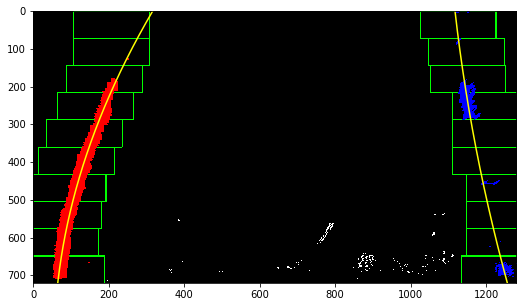

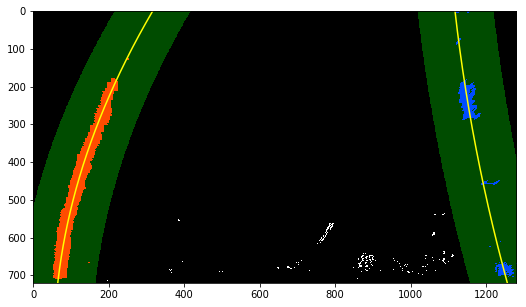

In [144]:
plt.figure(figsize=(10, 5))
lane = Line()
left_lane_inds, right_lane_inds, out_img = get_fits_sliding_window(warped_img)
lane.update_fit(warped_img, left_lane_inds, right_lane_inds)
display_line_fit(warped_img, left_lane_inds, right_lane_inds, out_img, False)

plt.figure(figsize=(10, 5))
left_lane_inds, right_lane_inds, out_img = get_fits_using_prev(warped_img, lane.left_fit, lane.right_fit)
lane.update_fit(warped_img, left_lane_inds, right_lane_inds)
display_line_fit(warped_img, left_lane_inds, right_lane_inds, out_img, True)

## 6. Determine lane curvature

In [101]:
def image_pipeline(img, mtx=None, dist=None, lane_prev=None):
    """Process each dashcam image to identify lanes
    
    Parameters
    ----------
    img : numpy array
        Dashcam image represented as array
    
    mtx : numpy array
        Camera matrix
        
    dist : numpy array
        Distortion coefficients
    
    lane_prev : Line obj
        Obj for previously identified lane
    
    Returns
    -------
    final_result : numpy array
        Image with lines drawn to identify lanes and general info text added
    """
    new_img = np.copy(img)
    if mtx is None or dist is None:
         mtx, dist = calibrate_camera("./camera_cal/calibration*.jpg")

    undistorted_img = undistort(img, mtx, dist)
    binary_threshold = process_img(undistorted_img, s_thresh=(175,250), sx_thresh=(30,150))
    warped_img, M, Minv = warp(binary_threshold)

    left_lane_inds = None
    right_lane_inds = None
    out_img = None
    plot_search_area = True
    
    lane = Line()
    
    if lane_prev is None:
        left_lane_inds, right_lane_inds, out_img = get_fits_sliding_window(warped_img)
        plot_search_area = False
        lane.update_fit(warped_img, left_lane_inds, right_lane_inds)
    else:
        left_lane_inds, right_lane_inds, out_img = get_fits_using_prev(warped_img, \
                                                                    line_prev.left_fit, line_prev.right_fit)
        lane.update_fit(warped_img, left_lane_inds, right_lane_inds)

        if lane.check_fit(lane_prev) is False:
            left_lane_inds, right_lane_inds, out_img = get_fits_sliding_window(warped_img)
            plot_search_area = False
            lane.update_fit(warped_img, left_lane_inds, right_lane_inds)

    result = draw_lane(new_img, warped_img, lane.y_vals, lane.left_fit_x, lane.right_fit_x, Minv)

    final_result = draw_data(result, lane)

    lane_prev = lane
    return final_result

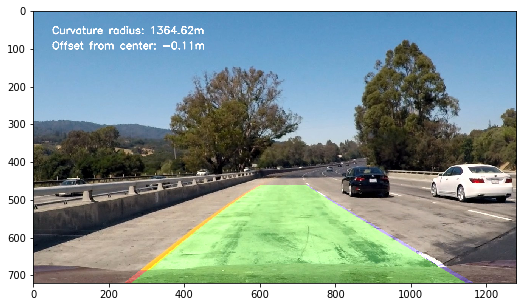

In [145]:
plt.figure(figsize=(10,5))
plt.imshow(image_pipeline(img))

## Process video

In [114]:
video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(image_pipeline)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [2:04:49<00:05,  5.94s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2h 9min 23s, sys: 3min 10s, total: 2h 12min 33s
Wall time: 2h 4min 50s


In [163]:
from moviepy.editor import *

clip = (VideoFileClip("project_video_output.mp4")
        .subclip((0,0),(0,5))
        .resize(0.5))
clip.write_gif("project_output_bigger.gif")


[MoviePy] Building file project_output_bigger.gif with imageio


 99%|█████████▉| 125/126 [00:13<00:00,  9.34it/s]
